In [1]:
import os
import sys
import dask
import typer
import numpy
import shutil
import pyproj
import xarray
import pandas
import logging
import rioxarray
import geopandas
from pathlib import Path
from dask.distributed import Client
from geocube.api.core import make_geocube

In [2]:
client = Client(n_workers=2, memory_limit='7GB')
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 2
Total threads: 12,Total memory: 13.04 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52792,Workers: 2
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 13.04 GiB
Comm: tcp://127.0.0.1:52799,Total threads: 6
Dashboard: http://127.0.0.1:52802/status,Memory: 6.52 GiB
Nanny: tcp://127.0.0.1:52795,


## Attempt 2

In [3]:
geopackage = 'input-data/wb-2917533_upstream_subset.gpkg'
forcing = 'input-data/results.nc'

In [19]:
#ds, gdf = load_data(forcing, geopackage)

# load forcing data
ds = xarray.open_dataset(forcing)

# debugging
ds = ds.isel(time=range(0, 100))


# load hydrofabric
gdf = geopandas.read_file(geopackage, layer='divides')

# convert these data into the projection of our forcing data
# this assumes that we're using AORC forcing.
# TODO: generalize this to use whatever projection is defined in the 
# forcing dataset
target_crs = pyproj.Proj(proj='lcc',
                         lat_1=30.,
                         lat_2=60., 
                         lat_0=40.0000076293945, lon_0=-97.,
                         a=6370000, b=6370000)
gdf = gdf.to_crs(target_crs.crs)


    

In [20]:
ds

<xarray.Dataset>
Dimensions:              (latitude: 57, longitude: 96, time: 100)
Coordinates:
  * latitude             (latitude) float64 40.24 40.25 40.26 ... 40.7 40.71
  * longitude            (longitude) float64 -111.7 -111.7 ... -110.9 -110.9
  * time                 (time) datetime64[ns] 2020-01-01 ... 2020-01-05T03:0...
Data variables:
    spatial_ref          int64 ...
    APCP_surface         (time, latitude, longitude) float32 ...
    DLWRF_surface        (time, latitude, longitude) float32 ...
    DSWRF_surface        (time, latitude, longitude) float32 ...
    PRES_surface         (time, latitude, longitude) float32 ...
    SPFH_2maboveground   (time, latitude, longitude) float32 ...
    TMP_2maboveground    (time, latitude, longitude) float32 ...
    UGRD_10maboveground  (time, latitude, longitude) float32 ...
    VGRD_10maboveground  (time, latitude, longitude) float32 ...

In [22]:
# zonal_ds = prepare_zonal(scattered_ds, scattered_gdf)


# create zonal id column
gdf['cat'] = gdf.id.str.split('-').str[-1].astype(int)

# set the aorc crs.
# TODO: This should be set when the dataset is saved, not here.
ds =  ds.rio.write_crs('EPSG:4326', inplace=True)

# create a grid for the geocube
out_grid = make_geocube(
    vector_data=gdf,
    measurements=["cat"],
    like=ds # ensure the data are on the same grid
)

# add the catchment variable to the original dataset
ds = ds.assign_coords(cat = (['latitude', 'longitude'], out_grid.cat.data))


In [24]:
catchment_ids = numpy.unique(ds.cat.data[~numpy.isnan(ds.cat.data)])

In [25]:
catchment_ids[0:10]

array([2917496., 2917497., 2917498., 2917499., 2917500., 2917501.,
       2917502., 2917503., 2917504., 2917505.])

In [26]:
cat_id = catchment_ids[0]
cat_id

2917496.0

In [27]:
ds

<xarray.Dataset>
Dimensions:              (latitude: 57, longitude: 96, time: 100)
Coordinates:
  * latitude             (latitude) float64 40.24 40.25 40.26 ... 40.7 40.71
  * longitude            (longitude) float64 -111.7 -111.7 ... -110.9 -110.9
  * time                 (time) datetime64[ns] 2020-01-01 ... 2020-01-05T03:0...
    spatial_ref          int64 0
    cat                  (latitude, longitude) float64 2.918e+06 ... nan
Data variables:
    APCP_surface         (time, latitude, longitude) float32 ...
    DLWRF_surface        (time, latitude, longitude) float32 ...
    DSWRF_surface        (time, latitude, longitude) float32 ...
    PRES_surface         (time, latitude, longitude) float32 ...
    SPFH_2maboveground   (time, latitude, longitude) float32 ...
    TMP_2maboveground    (time, latitude, longitude) float32 ...
    UGRD_10maboveground  (time, latitude, longitude) float32 ...
    VGRD_10maboveground  (time, latitude, longitude) float32 ...

In [28]:
ds.isel(time=0).APCP_surface.sum()

<xarray.DataArray 'APCP_surface' ()>
array(378.7, dtype=float32)
Coordinates:
    time         datetime64[ns] 2020-01-01
    spatial_ref  int64 0

In [39]:
ds

<xarray.Dataset>
Dimensions:              (latitude: 57, longitude: 96, time: 100)
Coordinates:
  * latitude             (latitude) float64 40.24 40.25 40.26 ... 40.7 40.71
  * longitude            (longitude) float64 -111.7 -111.7 ... -110.9 -110.9
  * time                 (time) datetime64[ns] 2020-01-01 ... 2020-01-05T03:0...
    spatial_ref          int64 0
    cat                  (latitude, longitude) float64 2.918e+06 ... nan
Data variables:
    APCP_surface         (time, latitude, longitude) float32 0.0 0.0 ... nan nan
    DLWRF_surface        (time, latitude, longitude) float32 234.9 234.1 ... nan
    DSWRF_surface        (time, latitude, longitude) float32 4.5 4.4 ... nan nan
    PRES_surface         (time, latitude, longitude) float32 8.66e+04 ... nan
    SPFH_2maboveground   (time, latitude, longitude) float32 0.003 0.003 ... nan
    TMP_2maboveground    (time, latitude, longitude) float32 272.3 272.2 ... nan
    UGRD_10maboveground  (time, latitude, longitude) float32 0.0 0.0 ... nan nan
    VGRD_10maboveground  (time, latitude, longitude) float32 0.0 0.0 ... nan nan

In [49]:
ds_mean = ds.groupby(ds.cat).mean().resample(time='24h').sum()

In [51]:
ds_mean.isel(time=0)

<xarray.Dataset>
Dimensions:              (cat: 246)
Coordinates:
    spatial_ref          int64 0
  * cat                  (cat) float64 2.917e+06 2.917e+06 ... 2.918e+06
    time                 datetime64[ns] 2020-01-01
Data variables:
    APCP_surface         (cat) float32 12.32 12.49 12.91 ... 15.48 15.22 12.86
    DLWRF_surface        (cat) float32 5.841e+03 5.852e+03 ... 5.809e+03
    DSWRF_surface        (cat) float32 2.158e+03 2.162e+03 ... 2.158e+03
    PRES_surface         (cat) float32 1.661e+06 1.684e+06 ... 1.686e+06
    SPFH_2maboveground   (cat) float32 0.07135 0.07203 ... 0.06846 0.06917
    TMP_2maboveground    (cat) float32 6.408e+03 6.435e+03 ... 6.421e+03
    UGRD_10maboveground  (cat) float32 93.14 92.51 89.41 ... -22.08 15.52 48.02
    VGRD_10maboveground  (cat) float32 -87.75 -64.31 -46.96 ... 28.74 -49.63

In [31]:
d = ds.where(ds.cat==cat_id, drop=True)

In [32]:
d

<xarray.Dataset>
Dimensions:              (time: 100, latitude: 5, longitude: 5)
Coordinates:
  * latitude             (latitude) float64 40.67 40.68 40.69 40.7 40.71
  * longitude            (longitude) float64 -111.0 -111.0 -111.0 -111.0 -110.9
  * time                 (time) datetime64[ns] 2020-01-01 ... 2020-01-05T03:0...
    spatial_ref          int64 0
    cat                  (latitude, longitude) float64 2.918e+06 ... nan
Data variables:
    APCP_surface         (time, latitude, longitude) float32 nan nan ... 0.0 nan
    DLWRF_surface        (time, latitude, longitude) float32 nan nan ... nan
    DSWRF_surface        (time, latitude, longitude) float32 nan nan ... 0.0 nan
    PRES_surface         (time, latitude, longitude) float32 nan nan ... nan
    SPFH_2maboveground   (time, latitude, longitude) float32 nan nan ... nan
    TMP_2maboveground    (time, latitude, longitude) float32 nan nan ... nan
    UGRD_10maboveground  (time, latitude, longitude) float32 nan nan ... 3.6 nan
    VGRD_10maboveground  (time, latitude, longitude) float32 nan nan ... nan

In [33]:
d.isel(time=0)

<xarray.Dataset>
Dimensions:              (latitude: 5, longitude: 5)
Coordinates:
  * latitude             (latitude) float64 40.67 40.68 40.69 40.7 40.71
  * longitude            (longitude) float64 -111.0 -111.0 -111.0 -111.0 -110.9
    time                 datetime64[ns] 2020-01-01
    spatial_ref          int64 0
    cat                  (latitude, longitude) float64 2.918e+06 ... nan
Data variables:
    APCP_surface         (latitude, longitude) float32 nan nan nan ... 0.0 nan
    DLWRF_surface        (latitude, longitude) float32 nan nan nan ... 209.4 nan
    DSWRF_surface        (latitude, longitude) float32 nan nan nan ... 0.0 nan
    PRES_surface         (latitude, longitude) float32 nan nan ... 6.887e+04 nan
    SPFH_2maboveground   (latitude, longitude) float32 nan nan ... 0.0019 nan
    TMP_2maboveground    (latitude, longitude) float32 nan nan nan ... 264.8 nan
    UGRD_10maboveground  (latitude, longitude) float32 nan nan nan ... 1.4 nan
    VGRD_10maboveground  (latitude, longitude) float32 nan nan nan ... -3.7 nan

In [15]:
d_mean = d.mean(dim=['x', 'y'])

In [16]:
d_mean.isel(time=0).APCP_surface.sum()

<xarray.DataArray 'APCP_surface' ()>
array(378.7, dtype=float32)
Coordinates:
    time         datetime64[ns] 2020-01-01
    spatial_ref  int64 0

In [ ]:
d = d.mean(dim=['x','y']).resample(time="1h").mean()

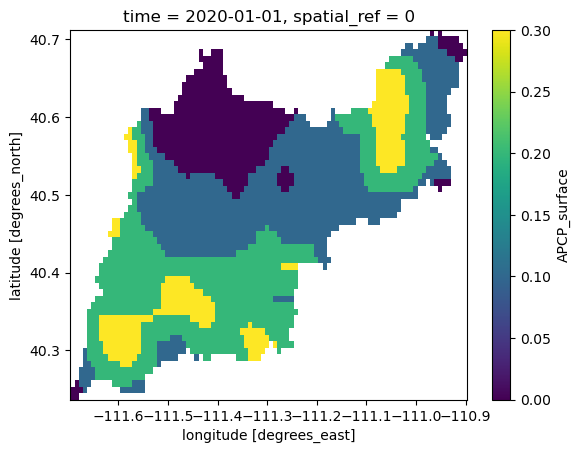

In [25]:
ds.where(ds.cat==cat_id, drop=True).isel(time=0).APCP_surface.mean(dim=['x','y']).plot()

In [20]:
ds

<xarray.Dataset>
Dimensions:              (latitude: 57, longitude: 96, time: 100, y: 57, x: 96)
Coordinates:
  * latitude             (latitude) float64 40.24 40.25 40.26 ... 40.7 40.71
  * longitude            (longitude) float64 -111.7 -111.7 ... -110.9 -110.9
  * time                 (time) datetime64[ns] 2020-01-01 ... 2020-01-05T03:0...
    spatial_ref          int64 0
    cat                  (y, x) float64 2.918e+06 2.918e+06 nan ... nan nan nan
Dimensions without coordinates: y, x
Data variables:
    APCP_surface         (time, latitude, longitude) float32 ...
    DLWRF_surface        (time, latitude, longitude) float32 ...
    DSWRF_surface        (time, latitude, longitude) float32 ...
    PRES_surface         (time, latitude, longitude) float32 ...
    SPFH_2maboveground   (time, latitude, longitude) float32 ...
    TMP_2maboveground    (time, latitude, longitude) float32 ...
    UGRD_10maboveground  (time, latitude, longitude) float32 ...
    VGRD_10maboveground  (time, latitude, longitude) float32 ...

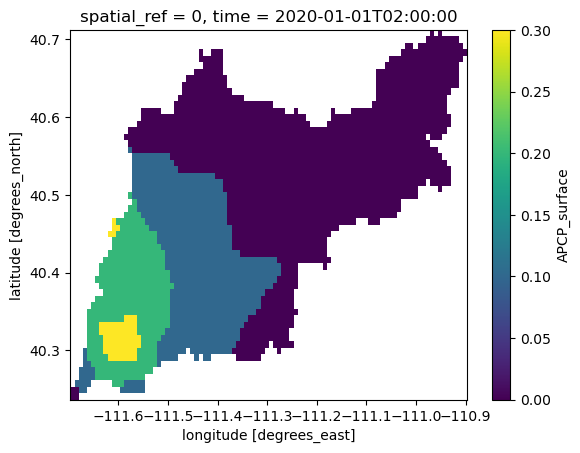

In [15]:
d.isel(time=2).APCP_surface.plot()

In [11]:
d

<xarray.Dataset>
Dimensions:              (time: 100, latitude: 57, longitude: 96)
Coordinates:
  * latitude             (latitude) float64 40.24 40.25 40.26 ... 40.7 40.71
  * longitude            (longitude) float64 -111.7 -111.7 ... -110.9 -110.9
    spatial_ref          int64 0
  * time                 (time) datetime64[ns] 2020-01-01 ... 2020-01-05T03:0...
Data variables:
    APCP_surface         (time, latitude, longitude) float32 0.0 0.0 ... nan nan
    DLWRF_surface        (time, latitude, longitude) float32 234.9 234.1 ... nan
    DSWRF_surface        (time, latitude, longitude) float32 4.5 4.4 ... nan nan
    PRES_surface         (time, latitude, longitude) float32 8.66e+04 ... nan
    SPFH_2maboveground   (time, latitude, longitude) float32 0.003 0.003 ... nan
    TMP_2maboveground    (time, latitude, longitude) float32 272.3 272.2 ... nan
    UGRD_10maboveground  (time, latitude, longitude) float32 0.0 0.0 ... nan nan
    VGRD_10maboveground  (time, latitude, longitude) float32 0.0 0.0 ... nan nan

In [8]:
#r = delayed_zonal_computation(zonal_ds, variable)
ds.mean(dim=['x','y']).resample(time="1h").mean()

<xarray.Dataset>
Dimensions:              (latitude: 57, longitude: 96, time: 100)
Coordinates:
  * latitude             (latitude) float64 40.24 40.25 40.26 ... 40.7 40.71
  * longitude            (longitude) float64 -111.7 -111.7 ... -110.9 -110.9
    spatial_ref          int64 0
  * time                 (time) datetime64[ns] 2020-01-01 ... 2020-01-05T03:0...
Data variables:
    APCP_surface         (time, latitude, longitude) float32 0.0 0.0 ... nan nan
    DLWRF_surface        (time, latitude, longitude) float32 234.9 234.1 ... nan
    DSWRF_surface        (time, latitude, longitude) float32 4.5 4.4 ... nan nan
    PRES_surface         (time, latitude, longitude) float32 8.66e+04 ... nan
    SPFH_2maboveground   (time, latitude, longitude) float32 0.003 0.003 ... nan
    TMP_2maboveground    (time, latitude, longitude) float32 272.3 272.2 ... nan
    UGRD_10maboveground  (time, latitude, longitude) float32 0.0 0.0 ... nan nan
    VGRD_10maboveground  (time, latitude, longitude) float32 0.0 0.0 ... nan nan

In [20]:
%%time
dd = ds.groupby(ds.cat).mean()
#.resample(time="1h").mean()

CPU times: user 2.35 s, sys: 2.01 s, total: 4.36 s
Wall time: 4.27 s


In [39]:
ds

<xarray.Dataset>
Dimensions:              (latitude: 57, longitude: 96, time: 100, y: 57, x: 96)
Coordinates:
  * latitude             (latitude) float64 40.24 40.25 40.26 ... 40.7 40.71
  * longitude            (longitude) float64 -111.7 -111.7 ... -110.9 -110.9
  * time                 (time) datetime64[ns] 2020-01-01 ... 2020-01-05T03:0...
    spatial_ref          int64 0
    cat                  (y, x) float64 2.918e+06 2.918e+06 nan ... nan nan nan
Dimensions without coordinates: y, x
Data variables:
    APCP_surface         (time, latitude, longitude) float32 0.0 0.0 ... nan nan
    DLWRF_surface        (time, latitude, longitude) float32 234.9 234.1 ... nan
    DSWRF_surface        (time, latitude, longitude) float32 4.5 4.4 ... nan nan
    PRES_surface         (time, latitude, longitude) float32 8.66e+04 ... nan
    SPFH_2maboveground   (time, latitude, longitude) float32 0.003 0.003 ... nan
    TMP_2maboveground    (time, latitude, longitude) float32 272.3 272.2 ... nan
    UGRD_10maboveground  (time, latitude, longitude) float32 0.0 0.0 ... nan nan
    VGRD_10maboveground  (time, latitude, longitude) float32 0.0 0.0 ... nan nan

In [48]:
ds.where(ds.cat==2917533, drop=True).mean(

<xarray.Dataset>
Dimensions:              (time: 100, latitude: 57, longitude: 96, y: 6, x: 7)
Coordinates:
  * latitude             (latitude) float64 40.24 40.25 40.26 ... 40.7 40.71
  * longitude            (longitude) float64 -111.7 -111.7 ... -110.9 -110.9
  * time                 (time) datetime64[ns] 2020-01-01 ... 2020-01-05T03:0...
    spatial_ref          int64 0
    cat                  (y, x) float64 2.918e+06 2.918e+06 ... 2.918e+06
Dimensions without coordinates: y, x
Data variables:
    APCP_surface         (time, latitude, longitude, y, x) float32 0.0 ... nan
    DLWRF_surface        (time, latitude, longitude, y, x) float32 234.9 ... nan
    DSWRF_surface        (time, latitude, longitude, y, x) float32 4.5 ... nan
    PRES_surface         (time, latitude, longitude, y, x) float32 8.66e+04 ....
    SPFH_2maboveground   (time, latitude, longitude, y, x) float32 0.003 ... nan
    TMP_2maboveground    (time, latitude, longitude, y, x) float32 272.3 ... nan
    UGRD_10maboveground  (time, latitude, longitude, y, x) float32 0.0 ... nan
    VGRD_10maboveground  (time, latitude, longitude, y, x) float32 0.0 ... nan

In [50]:
dd.where(ds.cat==2917533, drop=True)

ValueError: Dimensions {'y', 'x'} do not exist. Expected one or more of Frozen({'latitude': 57, 'longitude': 96, 'time': 100, 'cat': 246})

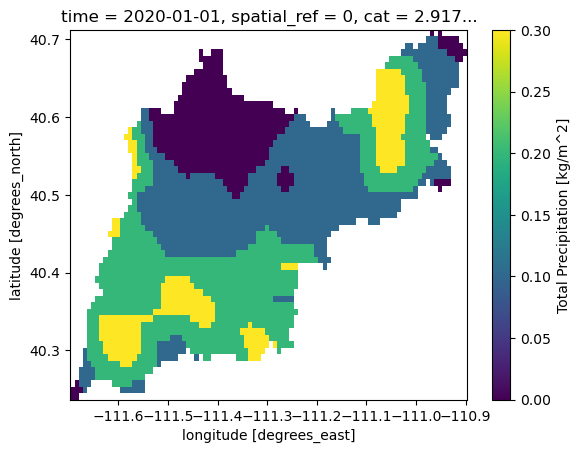

In [36]:
dd.isel(cat=0).isel(time=0).APCP_surface.plot()

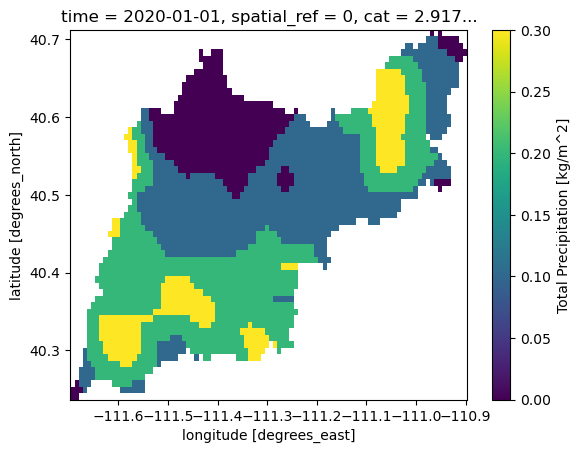

In [31]:
dd.isel(time=0, cat=1).APCP_surface.plot()

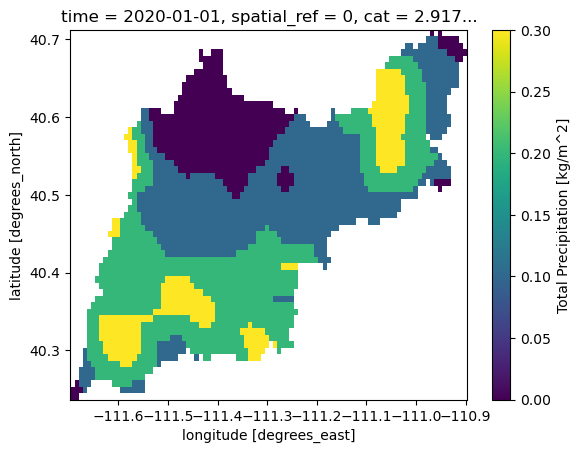

In [32]:
dd.isel(time=0, cat=2).APCP_surface.plot()

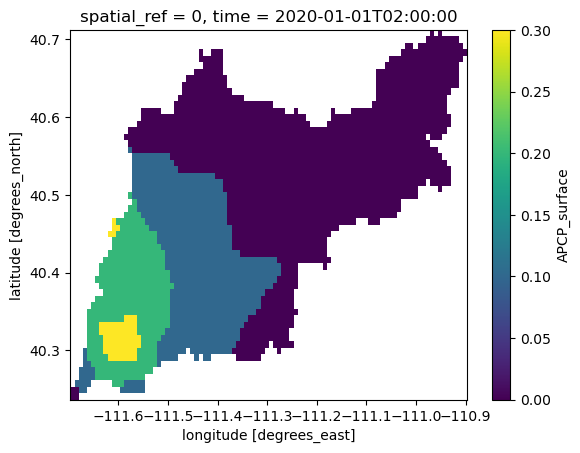

In [126]:
res[0][0].isel(time=2).APCP_surface.plot()

In [127]:
res[0][0]

<xarray.Dataset>
Dimensions:              (latitude: 57, longitude: 96, time: 8784)
Coordinates:
  * latitude             (latitude) float64 40.24 40.25 40.26 ... 40.7 40.71
  * longitude            (longitude) float64 -111.7 -111.7 ... -110.9 -110.9
    spatial_ref          int64 0
  * time                 (time) datetime64[ns] 2020-01-01 ... 2020-12-31T23:0...
Data variables:
    APCP_surface         (time, latitude, longitude) float32 0.0 0.0 ... nan nan
    DLWRF_surface        (time, latitude, longitude) float32 234.9 234.1 ... nan
    DSWRF_surface        (time, latitude, longitude) float32 4.5 4.4 ... nan nan
    PRES_surface         (time, latitude, longitude) float32 8.66e+04 ... nan
    SPFH_2maboveground   (time, latitude, longitude) float32 0.003 0.003 ... nan
    TMP_2maboveground    (time, latitude, longitude) float32 272.3 272.2 ... nan
    UGRD_10maboveground  (time, latitude, longitude) float32 0.0 0.0 ... nan nan
    VGRD_10maboveground  (time, latitude, longitude) float32 0.0 0.0 ... nan nan

In [113]:
ds = prepare_zonal(scattered_ds, scattered_gdf)

In [115]:
dat = dask.compute(ds)

In [117]:
dat[0]

<xarray.Dataset>
Dimensions:              (latitude: 57, longitude: 96, time: 8784, y: 57, x: 96)
Coordinates:
  * latitude             (latitude) float64 40.24 40.25 40.26 ... 40.7 40.71
  * longitude            (longitude) float64 -111.7 -111.7 ... -110.9 -110.9
  * time                 (time) datetime64[ns] 2020-01-01 ... 2020-12-31T23:0...
    spatial_ref          int64 0
    cat                  (y, x) float64 2.918e+06 2.918e+06 nan ... nan nan nan
Dimensions without coordinates: y, x
Data variables:
    APCP_surface         (time, latitude, longitude) float32 0.0 0.0 ... nan nan
    DLWRF_surface        (time, latitude, longitude) float32 234.9 234.1 ... nan
    DSWRF_surface        (time, latitude, longitude) float32 4.5 4.4 ... nan nan
    PRES_surface         (time, latitude, longitude) float32 8.66e+04 ... nan
    SPFH_2maboveground   (time, latitude, longitude) float32 0.003 0.003 ... nan
    TMP_2maboveground    (time, latitude, longitude) float32 272.3 272.2 ... nan
    UGRD_10maboveground  (time, latitude, longitude) float32 0.0 0.0 ... nan nan
    VGRD_10maboveground  (time, latitude, longitude) float32 0.0 0.0 ... nan nan

<Axes: >

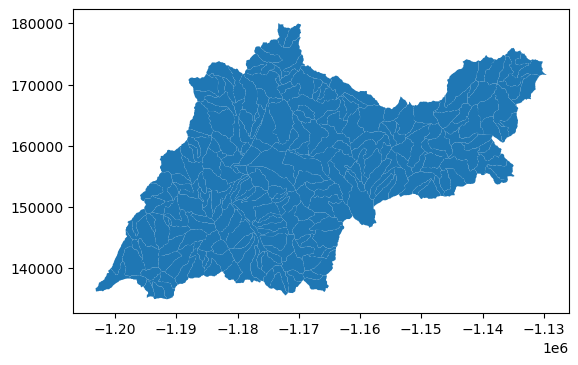

In [108]:
gdf.plot()

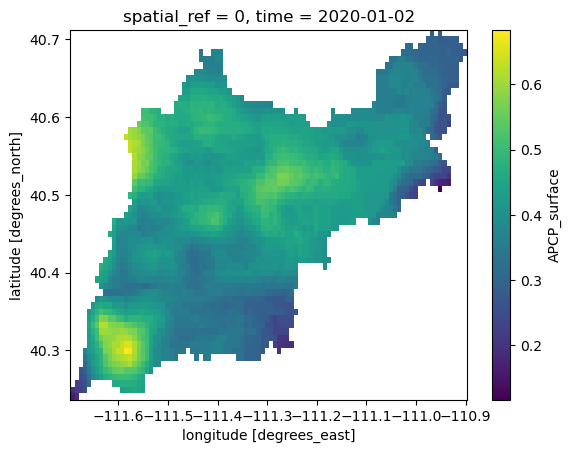

In [109]:
res[0][0].isel(time=1).APCP_surface.plot()

In [56]:
r = {k: v for d in res[0] for k, v in d.items()}
    
    # # return results
    # return {f'cat-{int(cat_id)}': res}

In [62]:
r['cat-2917496']['VGRD_10maboveground']

<bound method Mapping.values of <xarray.Dataset>
Dimensions:              (time: 100, latitude: 57, longitude: 96)
Coordinates:
  * latitude             (latitude) float64 40.24 40.25 40.26 ... 40.7 40.71
  * longitude            (longitude) float64 -111.7 -111.7 ... -110.9 -110.9
  * time                 (time) datetime64[ns] 2020-01-01 ... 2020-01-05T03:0...
    spatial_ref          int64 0
Data variables:
    APCP_surface         (time, latitude, longitude) float32 0.0 0.0 ... nan nan
    DLWRF_surface        (time, latitude, longitude) float32 234.9 234.1 ... nan
    DSWRF_surface        (time, latitude, longitude) float32 4.5 4.4 ... nan nan
    PRES_surface         (time, latitude, longitude) float32 8.66e+04 ... nan
    SPFH_2maboveground   (time, latitude, longitude) float32 0.003 0.003 ... nan
    TMP_2maboveground    (time, latitude, longitude) float32 272.3 272.2 ... nan
    UGRD_10maboveground  (time, latitude, longitude) float32 0.0 0.0 ... nan nan
    VGRD_10maboveground 

In [57]:
pandas.DataFrame({k:list(v) for k,v in r.items()})

,cat-2917496
0,VGRD_10maboveground


In [52]:
df = pandas.DataFrame(r)

In [53]:
df

,cat-2917496
VGRD_10maboveground,<bound method Mapping.values of <xarray.Datase...


In [16]:
%time
ds.where(ds.cat==catchment_ids[0], drop=True)

<xarray.Dataset>
Dimensions:              (time: 8784, latitude: 57, longitude: 96, y: 5, x: 5)
Coordinates:
  * latitude             (latitude) float64 40.24 40.25 40.26 ... 40.7 40.71
  * longitude            (longitude) float64 -111.7 -111.7 ... -110.9 -110.9
  * time                 (time) datetime64[ns] 2020-01-01 ... 2020-12-31T23:0...
    spatial_ref          int64 0
    cat                  (y, x) float64 2.918e+06 2.918e+06 ... 2.917e+06 nan
Dimensions without coordinates: y, x
Data variables:
    APCP_surface         (time, latitude, longitude, y, x) float32 nan ... nan
    DLWRF_surface        (time, latitude, longitude, y, x) float32 nan ... nan
    DSWRF_surface        (time, latitude, longitude, y, x) float32 nan ... nan
    PRES_surface         (time, latitude, longitude, y, x) float32 nan ... nan
    SPFH_2maboveground   (time, latitude, longitude, y, x) float32 nan ... nan
    TMP_2maboveground    (time, latitude, longitude, y, x) float32 nan ... nan
    UGRD_10maboveground  (time, latitude, longitude, y, x) float32 nan ... nan
    VGRD_10maboveground  (time, latitude, longitude, y, x) float32 nan ... nan

In [13]:

res = dask.compute(r)

In [14]:
res

({'cat-2917496': {'DLWRF_surface': <bound method Mapping.values of <xarray.Dataset>
   Dimensions:              (latitude: 57, longitude: 96, time: 8784)
   Coordinates:
     * latitude             (latitude) float64 40.24 40.25 40.26 ... 40.7 40.71
     * longitude            (longitude) float64 -111.7 -111.7 ... -110.9 -110.9
     * time                 (time) datetime64[ns] 2020-01-01 ... 2020-12-31T23:0...
       spatial_ref          int64 0
   Data variables:
       APCP_surface         (time, latitude, longitude) float32 0.0 0.0 ... nan nan
       DLWRF_surface        (time, latitude, longitude) float32 234.9 234.1 ... nan
       DSWRF_surface        (time, latitude, longitude) float32 4.5 4.4 ... nan nan
       PRES_surface         (time, latitude, longitude) float32 8.66e+04 ... nan
       SPFH_2maboveground   (time, latitude, longitude) float32 0.003 0.003 ... nan
       TMP_2maboveground    (time, latitude, longitude) float32 272.3 272.2 ... nan
       UGRD_10maboveground  (t

In [ ]:
# loop over each catchment in our domain
# create delayed tasks to compute zonal mean 
all_results = []
for cat_id in catchment_ids:
    results = []
    for variable in ['DLWRF_surface',
                     'PRES_surface',
                     'SPFH_2maboveground',
                     'APCP_surface',
                     'DSWRF_surface',
                     'TMP_2maboveground',
                     'UGRD_10maboveground',
                     'VGRD_10maboveground']:
        zonal_res = delayed_zonal_computation(scattered_ds, cat_id, variable)
    res = {k: v for d in results for k, v in d.items()}
    all_results.append(res)

    break # for test -> remove